# 2. Evaluacion modelos de clasificacion multiclase con redes LSTM
***


### Caso de estudio #2


### Tecnicas de ajuste de los datos y modelos:

| Ingeniería de datos       | Si / No       |
| :-------                  | :------:    |
| Escalado de datos         | Si          |
| Ajuste de arquitectura | Si        |
| Sobremuestreo             | No          |
| Ajuste de pesos de clase  | No          |



In [1]:

# librerias
import numpy as np
import math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score
from plot_metric.functions import BinaryClassification
from sklearn.metrics import classification_report
from sklearn import preprocessing

import os
import h5py
from sklearn import datasets 
from keras.models import model_from_json


from numba import cuda
from pandas import DataFrame
from numpy import array
from matplotlib import pyplot

from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from keras.models import load_model



Using TensorFlow backend.


In [34]:
# MULTICLASE funcion para generar matriz de confusion y medidas de desempeño del modelos clasificacion multiclase
def model_evaluation_multi(data_train, label_train2, data_test, label_test2, modelo, label_pred):
    print('\n')
    print("MATRIZ DE CONFUSION")
    print('\n')
    matriz = confusion_matrix(label_test2, label_pred)
    #print(matriz)
    classes = ["Funcional","Falla comp1","Falla comp2","Falla comp3","Falla comp4"]
    cm = ConfusionMatrix(modelo, classes=classes, label_encoder={0:"Funcional", 1:"Falla comp1", 2:"Falla comp2", 3:"Falla comp3", 4:"Falla comp4"})
    cm.fit(data_train, label_train2)
    cm.score(data_test, label_test2)
    cm.show()
    # Medidas de desempeño del modelo
    print('\n')
    print("MEDIDAS DE DESEMPEÑO DEL MODELO")
    print('\n')
    print('Exactitud - Accuracy: {}'.format(modelo.score(data_test, label_test2)))
    print('-'*60)
    print('Precisión por clase: {}'.format(metrics.precision_score(label_test2, label_pred, average=None)))
    print('Sensibilidad - Recall por clase: {}'.format(metrics.recall_score(label_test2, label_pred, average=None)))
    print('F1 por clase: {}'.format(metrics.f1_score(label_test2, label_pred, average=None)))
    print('-'*60)
    print('F1 Macro: {}'.format(metrics.f1_score(label_test2, label_pred, average='macro')))
    print('F1 Micro: {}'.format(metrics.f1_score(label_test2, label_pred, average='micro')))
    print('F1 Weighted: {}'.format(metrics.f1_score(label_test2, label_pred, average='weighted')))
    print('-'*60)
    print('Sensibilidad - Recall Macro: {}'.format(metrics.recall_score(label_test2, label_pred, average='macro')))
    print('Sensibilidad - Recall Micro: {}'.format(metrics.recall_score(label_test2, label_pred, average='micro')))
    print('Sensibilidad - Recall Weighted: {}'.format(metrics.recall_score(label_test2, label_pred, average='weighted')))
    print('-'*60)
    print('Precisión Macro: {}'.format(metrics.precision_score(label_test2, label_pred, average='macro')))
    print('Precisión Micro: {}'.format(metrics.precision_score(label_test2, label_pred, average='micro')))
    print('Precisión Weighted: {}'.format(metrics.precision_score(label_test2, label_pred, average='weighted')))
        
    print('-'*60)
   
    print(classification_report(label_test2, label_pred))
    

In [25]:
# funcion para graficar curva de aprendizaje
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

In [3]:
# cargar datos
test = pd.read_excel (r'D:\alexh\Documents\Maestria en estadistica\proyecto de grado\datos simulacion\test11.xlsx')
train = pd.read_excel (r'D:\alexh\Documents\Maestria en estadistica\proyecto de grado\datos simulacion\train11.xlsx')

In [4]:
train.head()

,datetime,id,volt,rotate,pressure,vibration,error1,error2,error3,error4,error5,mto_comp1,mto_comp2,mto_comp3,mto_comp4,model,age,failure
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,0,0,0,0,0,0,0,0,0,3,18,0
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,0,0,0,0,0,0,0,0,0,3,18,0
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,0,0,0,0,0,0,0,0,0,3,18,0
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,0,0,0,0,0,0,0,0,0,3,18,0
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,0,0,0,0,0,0,0,0,0,3,18,0


In [5]:
test.head()

,datetime,id,volt,rotate,pressure,vibration,error1,error2,error3,error4,error5,mto_comp1,mto_comp2,mto_comp3,mto_comp4,model,age,failure
0,2015-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864,0,0,0,0,0,0,0,0,0,3,8,0
1,2015-01-01 07:00:00,3,179.818516,519.166185,109.318603,37.290722,0,0,0,0,0,0,0,0,0,3,8,0
2,2015-01-01 08:00:00,3,165.616803,467.107482,101.285580,34.530035,0,0,0,0,0,0,0,0,0,3,8,0
3,2015-01-01 09:00:00,3,165.007013,391.994872,98.825669,27.495507,0,0,0,0,0,0,0,0,0,3,8,0
4,2015-01-01 10:00:00,3,138.898164,488.764118,102.800017,44.698218,0,0,0,0,0,0,0,0,0,3,8,0


In [6]:
type(train)

pandas.core.frame.DataFrame

In [7]:
variables=['volt','rotate','pressure','vibration','error1','error2','error3','error4','error5','mto_comp1','mto_comp2','mto_comp3','mto_comp4','model','age']

objetivo='failure'

In [8]:
# estandarizado de datos sin incluir id
scaler = StandardScaler()
train[variables]=scaler.fit_transform(train[variables])
test[variables]=scaler.transform(test[variables])
train.head()


,datetime,id,volt,rotate,pressure,vibration,error1,error2,error3,error4,error5,mto_comp1,mto_comp2,mto_comp3,mto_comp4,model,age,failure
0,2015-01-01 06:00:00,1,0.350986,-0.534618,1.105902,0.879350,-0.033998,-0.033477,-0.030712,-0.028355,-0.01913,-0.028612,-0.029767,-0.028943,-0.029019,0.159826,1.195669,0
1,2015-01-01 07:00:00,1,-0.508982,-0.834013,-0.488294,0.567226,-0.033998,-0.033477,-0.030712,-0.028355,-0.01913,-0.028612,-0.029767,-0.028943,-0.029019,0.159826,1.195669,0
2,2015-01-01 08:00:00,1,0.013930,1.533590,-2.318235,-1.154994,-0.033998,-0.033477,-0.030712,-0.028355,-0.01913,-0.028612,-0.029767,-0.028943,-0.029019,0.159826,1.195669,0
3,2015-01-01 09:00:00,1,-0.535828,-1.909450,0.759382,0.139832,-0.033998,-0.033477,-0.030712,-0.028355,-0.01913,-0.028612,-0.029767,-0.028943,-0.029019,0.159826,1.195669,0
4,2015-01-01 10:00:00,1,-0.848698,-0.214013,0.998102,-2.682002,-0.033998,-0.033477,-0.030712,-0.028355,-0.01913,-0.028612,-0.029767,-0.028943,-0.029019,0.159826,1.195669,0


In [9]:
print("numero de dimensiones train =", train.ndim)
print("tamaño de la tabla train=", train.shape)
print("total datos train =", train.size)
print("numero de dimensiones test =", test.ndim)
print("tamaño de la tabla test=", test.shape)
print("total datos test=", test.size)

numero de dimensiones train = 2
tamaño de la tabla train= (683388, 18)
total datos train = 12300984
numero de dimensiones test = 2
tamaño de la tabla test= (192752, 18)
total datos test= 3469536


In [10]:
# funcion para adaptar datos como lo requiere LSTM
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

# function to generate labels
def gen_label(id_df, seq_length, seq_cols,label):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

In [11]:
secuencia=30
columnas_secuencia=variables

In [12]:
# generar data_train
data_train=np.concatenate(list(list(gen_sequence(train[train['id']==id], secuencia, columnas_secuencia)) for id in train['id'].unique()))
# generar label_train
label_train=np.concatenate(list(list(gen_label(train[train['id']==id], secuencia, columnas_secuencia,'failure')) for id in train['id'].unique()))

In [13]:
# generar data_test
data_test=np.concatenate(list(list(gen_sequence(test[test['id']==id], secuencia, columnas_secuencia)) for id in test['id'].unique()))
# generar label_test
label_test=np.concatenate(list(list(gen_label(test[test['id']==id], secuencia, columnas_secuencia,'failure')) for id in test['id'].unique()))

In [14]:
print("numero de dimensiones Data_train =", data_train.ndim)
print("tamaño de la tabla Data_train =", data_train.shape)
print("total datos Data_train =", data_train.size)
print('-'*60)
print("numero de dimensiones Label_train =", label_train.ndim)
print("tamaño de la tabla Label_train =", label_train.shape)
print("total datos Label_train =", label_train.size)
print('-'*60)
print("numero de dimensiones Data_test =", data_test.ndim)
print("tamaño de la tabla Data_test =", data_test.shape)
print("total datos Data_test =", data_test.size)
print('-'*60)
print("numero de dimensiones Label_test =", label_test.ndim)
print("tamaño de la tabla Label_test =", label_test.shape)
print("total datos Label_test =", label_test.size)

numero de dimensiones Data_train = 3
tamaño de la tabla Data_train = (683310, 30, 15)
total datos Data_train = 307489500
------------------------------------------------------------
numero de dimensiones Label_train = 1
tamaño de la tabla Label_train = (683310,)
total datos Label_train = 683310
------------------------------------------------------------
numero de dimensiones Data_test = 3
tamaño de la tabla Data_test = (192730, 30, 15)
total datos Data_test = 86728500
------------------------------------------------------------
numero de dimensiones Label_test = 1
tamaño de la tabla Label_test = (192730,)
total datos Label_test = 192730


In [15]:
print(label_train)

[0. 0. 0. ... 0. 0. 0.]


In [17]:
# convertir la variable etiqueta en categorico
label_train = to_categorical(label_train)

## Modelo Stacked LSTM

In [20]:
model_path_clf = 'classification_model.h5'  

nb_features =data_train.shape[2]
timestamp=secuencia

modelolstm2 = Sequential()
modelolstm2.add(LSTM(input_shape=(timestamp, nb_features), units=100,return_sequences=True))
modelolstm2.add(Dropout(0.2))
modelolstm2.add(LSTM(units=50, return_sequences=False))
modelolstm2.add(Dropout(0.2))
modelolstm2.add(Dense(units=5, activation='softmax'))
modelolstm2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(modelolstm2.summary())

# fitting
history = modelolstm2.fit(data_train, label_train, epochs=30, batch_size=128, validation_split=0.1, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           46400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 255       
Total params: 76,855
Trainable params: 76,855
Non-trainable params: 0
_________________________________________________________________
None
Instructions

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

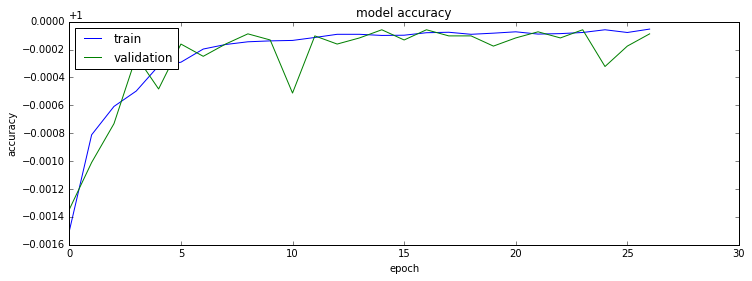

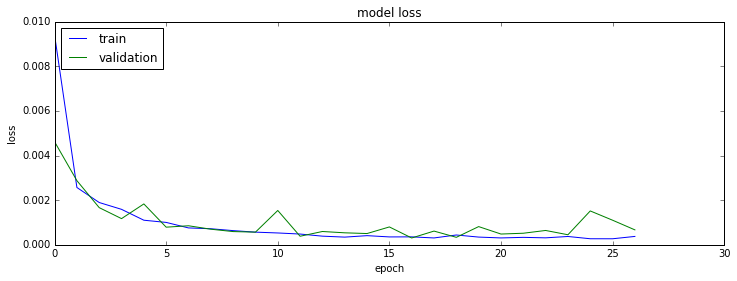

In [26]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

Ajuste de perdida entre los datos de entrenamiento y validacion en nivel aceptable 

In [27]:
# cargar el mejor modelo guardado durante el entrenamiento
saved_model = load_model('classification_model.h5')

In [29]:
label_pred=saved_model.predict_classes(data_test)

In [37]:
# metricas de desempeño del modelo:
matriz = confusion_matrix(label_test, label_pred)
print('Confusion Matrix: \n',confusion_matrix(label_test,label_pred))
print('\n')
print("MEDIDAS DE DESEMPEÑO DEL MODELO")
print('\n')
print('Exactitud - Accuracy: {}'.format(accuracy_score(label_test,label_pred)))

print('-'*60)
print('Precisión por clase: {}'.format(metrics.precision_score(label_test, label_pred, average=None)))
print('Sensibilidad - Recall por clase: {}'.format(metrics.recall_score(label_test, label_pred, average=None)))
print('F1 por clase: {}'.format(metrics.f1_score(label_test, label_pred, average=None)))
print('-'*60)
print('F1 Macro: {}'.format(metrics.f1_score(label_test, label_pred, average='macro')))
print('F1 Micro: {}'.format(metrics.f1_score(label_test, label_pred, average='micro')))
print('F1 Weighted: {}'.format(metrics.f1_score(label_test, label_pred, average='weighted')))
print('-'*60)
print('Sensibilidad - Recall Macro: {}'.format(metrics.recall_score(label_test, label_pred, average='macro')))
print('Sensibilidad - Recall Micro: {}'.format(metrics.recall_score(label_test, label_pred, average='micro')))
print('Sensibilidad - Recall Weighted: {}'.format(metrics.recall_score(label_test, label_pred, average='weighted')))
print('-'*60)
print('Precisión Macro: {}'.format(metrics.precision_score(label_test, label_pred, average='macro')))
print('Precisión Micro: {}'.format(metrics.precision_score(label_test, label_pred, average='micro')))
print('Precisión Weighted: {}'.format(metrics.precision_score(label_test, label_pred, average='weighted')))

Confusion Matrix: 
 [[192541      3      1      4      1]
 [     6     32      0      0      0]
 [     1      0     61      0      0]
 [     2      0      0     26      0]
 [     5      1      0      1     45]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9998702848544596
------------------------------------------------------------
Precisión por clase: [0.99992729 0.88888889 0.98387097 0.83870968 0.97826087]
Sensibilidad - Recall por clase: [0.99995326 0.84210526 0.98387097 0.92857143 0.86538462]
F1 por clase: [0.99994028 0.86486486 0.98387097 0.88135593 0.91836735]
------------------------------------------------------------
F1 Macro: 0.9296798775555162
F1 Micro: 0.9998702848544596
F1 Weighted: 0.9998692371831958
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9239771067499337
Sensibilidad - Recall Micro: 0.9998702848544596
Sensibilidad - Recall Weighted: 0.9998702848544596
-----------------------------------------------------

In [38]:
print(classification_report(label_test, label_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    192550
         1.0       0.89      0.84      0.86        38
         2.0       0.98      0.98      0.98        62
         3.0       0.84      0.93      0.88        28
         4.0       0.98      0.87      0.92        52

    accuracy                           1.00    192730
   macro avg       0.94      0.92      0.93    192730
weighted avg       1.00      1.00      1.00    192730



## Vanilla LSTM

In [40]:
model_path_clf = 'classification_model2.h5'  
nb_features =data_train.shape[2]
timestamp=secuencia

modelolstmv = Sequential()
modelolstmv.add(LSTM(25,input_shape=(timestamp, nb_features)))
modelolstmv.add(Dense(units=5, activation='softmax'))
modelolstmv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(modelolstmv.summary())

# entrenamiento
history = modelolstmv.fit(data_train, label_train, epochs=20, batch_size=128, validation_split=0.1, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 25)                4100      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 130       
Total params: 4,230
Trainable params: 4,230
Non-trainable params: 0
_________________________________________________________________
None
Train on 614979 samples, validate on 68331 samples
Epoch 1/20
614979/614979 [==============================] - 269s 437us/step - loss: 0.0181 - acc: 0.9965 - val_loss: 0.0058 - val_acc: 0.9989

Epoch 00001: val_loss improved from inf to 0.00578, saving model to classification_model2.h5
Epoch 2/20
614979/614979 [==============================] - 266s 433us/step - loss: 0.0032 - acc: 0.9991 - val_loss: 0.0028 - val_acc: 0.9988

Epoch 00002: val_loss improved from 0.00578 to 0.00279, saving model to classification_model2.h5
Epoc

In [44]:
# cargar el mejor modelo guardado durante el entrenamiento

saved_model = load_model('classification_model2.h5')

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

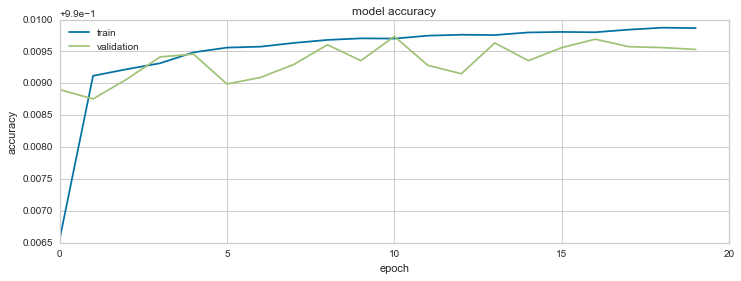

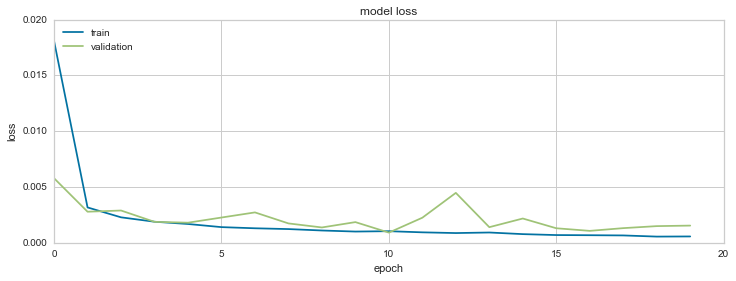

In [43]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

In [45]:
label_pred=saved_model.predict_classes(data_test)

In [36]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import classification_report

In [46]:
# metricas de desempeño del modelo
matriz = confusion_matrix(label_test, label_pred)
print('Confusion Matrix: \n',confusion_matrix(label_test,label_pred))
print('\n')
print("MEDIDAS DE DESEMPEÑO DEL MODELO")
print('\n')
print('Exactitud - Accuracy: {}'.format(accuracy_score(label_test,label_pred)))

print('-'*60)
print('Precisión por clase: {}'.format(metrics.precision_score(label_test, label_pred, average=None)))
print('Sensibilidad - Recall por clase: {}'.format(metrics.recall_score(label_test, label_pred, average=None)))
print('F1 por clase: {}'.format(metrics.f1_score(label_test, label_pred, average=None)))
print('-'*60)
print('F1 Macro: {}'.format(metrics.f1_score(label_test, label_pred, average='macro')))
print('F1 Micro: {}'.format(metrics.f1_score(label_test, label_pred, average='micro')))
print('F1 Weighted: {}'.format(metrics.f1_score(label_test, label_pred, average='weighted')))
print('-'*60)
print('Sensibilidad - Recall Macro: {}'.format(metrics.recall_score(label_test, label_pred, average='macro')))
print('Sensibilidad - Recall Micro: {}'.format(metrics.recall_score(label_test, label_pred, average='micro')))
print('Sensibilidad - Recall Weighted: {}'.format(metrics.recall_score(label_test, label_pred, average='weighted')))
print('-'*60)
print('Precisión Macro: {}'.format(metrics.precision_score(label_test, label_pred, average='macro')))
print('Precisión Micro: {}'.format(metrics.precision_score(label_test, label_pred, average='micro')))
print('Precisión Weighted: {}'.format(metrics.precision_score(label_test, label_pred, average='weighted')))

Confusion Matrix: 
 [[192538      3      6      1      2]
 [     8     30      0      0      0]
 [     4      0     57      1      0]
 [     8      0      0     20      0]
 [    12      0      0      0     40]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9997665127380273
------------------------------------------------------------
Precisión por clase: [0.99983383 0.90909091 0.9047619  0.90909091 0.95238095]
Sensibilidad - Recall por clase: [0.99993768 0.78947368 0.91935484 0.71428571 0.76923077]
F1 por clase: [0.99988575 0.84507042 0.912      0.8        0.85106383]
------------------------------------------------------------
F1 Macro: 0.8816040004437162
F1 Micro: 0.9997665127380273
F1 Weighted: 0.9997577602745098
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8384565369923491
Sensibilidad - Recall Micro: 0.9997665127380273
Sensibilidad - Recall Weighted: 0.9997665127380273
-----------------------------------------------------

In [47]:
print(classification_report(label_test, label_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    192550
         1.0       0.91      0.79      0.85        38
         2.0       0.90      0.92      0.91        62
         3.0       0.91      0.71      0.80        28
         4.0       0.95      0.77      0.85        52

    accuracy                           1.00    192730
   macro avg       0.94      0.84      0.88    192730
weighted avg       1.00      1.00      1.00    192730



Como se puede observar al comparar las metricas de desempeño, a pesar del desequilibrio severo que presentan los datos de entrenamiento y prueba, los modelos de DNN producen un resultado satisfactorio y no se afectan significativamente por esta condición de desequilibrio de clases, el modelo Stacked LSTM (apilado de varias capas LSTM) proporciona un resultado con un F1-macro del 93%, el cual supera por 17 puntos porcentuales el desempeño de los modelos de ML clásicos con ajuste de hiperparámetros